In [1]:
# !pip install tqdm
# !pip install matplotlib
# !pip install seaborn

%load_ext autoreload

%autoreload 2

In [2]:
import sys
import os
#make the self written stuff findeable independent on who downloads it
#sts.path.append( ) makes the module importable
# os.path.dirname(os.getcwd()) provides the parent directory
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)


current directory is : C:\Users\Utis\Documents\GitHub\tensorflow_1.X_playground\regression\notebooks
Directory name is : notebooks


In [4]:
from data.generators import ToyDataset


In [5]:
from helpers import _TFColor, colors, lazy_property
import helpers
TFColor = _TFColor()

In [6]:
import numpy as np

import matplotlib.pyplot as plt

matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

In [7]:
figsize(20,7)

In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
 
 
from tensorflow.python.platform import tf_logging as logging
 
#logging.set_verbosity(logging.INFO)
logging.set_verbosity(0)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)

In [9]:
from data.generators import ToyDataset

In [10]:
DATA_SEQ_LEN = 300#240


dataset = ToyDataset(DATA_SEQ_LEN,DATA_SEQ_LEN)
X, y = dataset.X, dataset.y

In [11]:
gdef = dataset.graph()

Now the shufflebuffer includes the whole dataset and we have loads of randomness in the sequence to work with.

In [12]:
#https://stackoverflow.com/questions/33748552/tensorflow-how-to-replace-a-node-in-a-calculation-graph

In [13]:
from models.networks import EnsembleNetwork, CopyNetwork
from models.ensembles import VanillaEnsemble, OnlineBootstrapEnsemble, BootstrapThroughTimeBobStrap

In [14]:
meta_epochs = 20
plt.figure(figsize = (16,8*meta_epochs))

<Figure size 1152x11520 with 0 Axes>

<Figure size 1152x11520 with 0 Axes>

In [15]:
seeds = [1,2,3,4,5]
layers = [
    [10, 50, 20, 30, 10],
    [100, 50],
    [30, 30, 30],
    [5, 10, 100],
    [50, 50, 50]
]

In [16]:
estimator_stats = [{
            'ds_graph' : gdef,
            'num_neurons': num_neurons,
            'num_epochs': 10,
            'seed':seed,
    'activations': [tf.nn.tanh,tf.nn.tanh,tf.nn.tanh,tf.nn.tanh,tf.nn.relu]
    #activagtions:tf.nn.relu  #tf.nn.tanh
        } for seed, num_neurons in zip(seeds,layers)]

In [17]:
#van = OnlineBootstrapEnsemble(gdef,num_epochs=10,estimator_stats=estimator_stats)
#van = VanillaEnsemble(gdef,num_epochs=10,estimator_stats=estimator_stats)
van = BootstrapThroughTimeBobStrap(gdef,num_epochs=10,estimator_stats=estimator_stats)






Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
initialising Network <class 'models.networks.CopyNetwork'>


In [18]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']

In [19]:
#len(van.estimator_list)

Instructions for updating:
Use standard file APIs to check for files with this prefix.


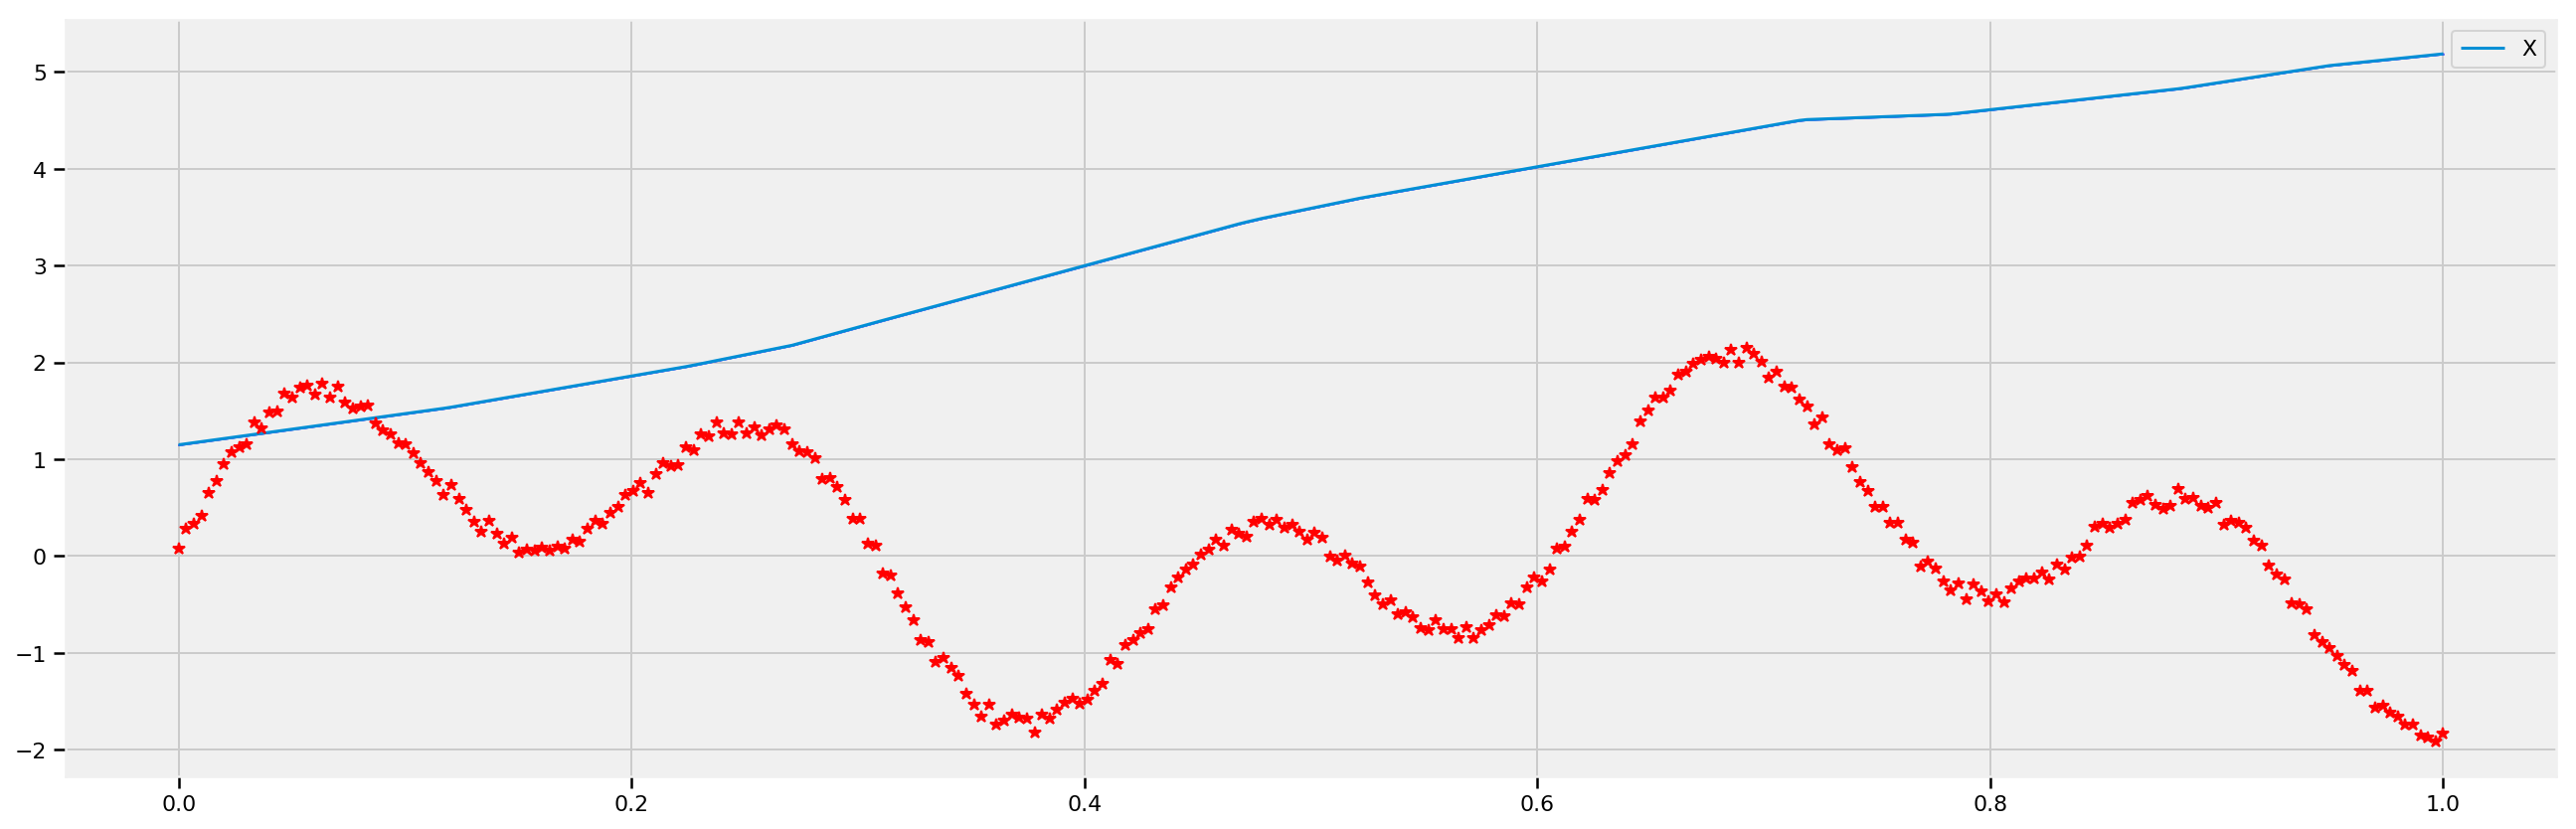

In [20]:
mean, var = get_mean_var(van.predict(X))

plt.plot(X,mean,label='X')
plt.plot(X,y,'r*')
plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3, color='b')
plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3, color='b')
plt.legend()

In [21]:
#van.predict(X)

In [22]:
#van.fit(1000)

In [23]:
# mean, var = get_mean_var(van.predict(X))

# plt.plot(X,mean,label='X')
# plt.plot(X,y,'r*')
# plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3, color='b')
# plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3, color='b')
# plt.legend()

In [24]:
# a = van.fit(100)

In [25]:
import tqdm

In [26]:
import numpy as np

import scipy 


def rmse(y_hat, y):
    return np.sqrt(np.mean((y_hat - y)**2))


def coverage_probability(prediction, variance, truth):
    CP = 0
    for y_hat, s, y in zip(prediction, variance, truth):
        if y_hat + s > y > y_hat - s:
            CP += 1

    #if (y - 2 * s < 0) and (y + 2 * s > 0):
    #    CP += 1
    return CP / len(truth)

def error_uncertainty_correlation(prediction,variance,truth):
    prediction, variance, truth = prediction.flatten(), variance.flatten(), truth.flatten()
    assert prediction.shape == truth.shape == variance.shape, 'shapes are: pred {} truth {} variance {}'.format(prediction.shape, truth.shape, variance.shape)
    error = (prediction - truth.flatten())**2
    correlation = scipy.stats.pearsonr(error.flatten(),variance.flatten())
    
    #np.correlate(error.flatten(),variance.flatten())
    return correlation

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Utis\Miniconda3\envs\tf_gpu\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den
C:\Users\Utis\Miniconda3\envs\tf_gpu\lib\site-packages\scipy\stats\stats.py:3042: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
C:\Users\Utis\Miniconda3\envs\tf_gpu\lib\site-packages\scipy\stats\stats.py:3042: RuntimeWarning: invalid value encountered in less
  r = max(min(r, 1.0), -1.0)


rsme is 3.533066749572754. 
 Coverage is 0.0. 
 COBEAU is (nan, 1.0).


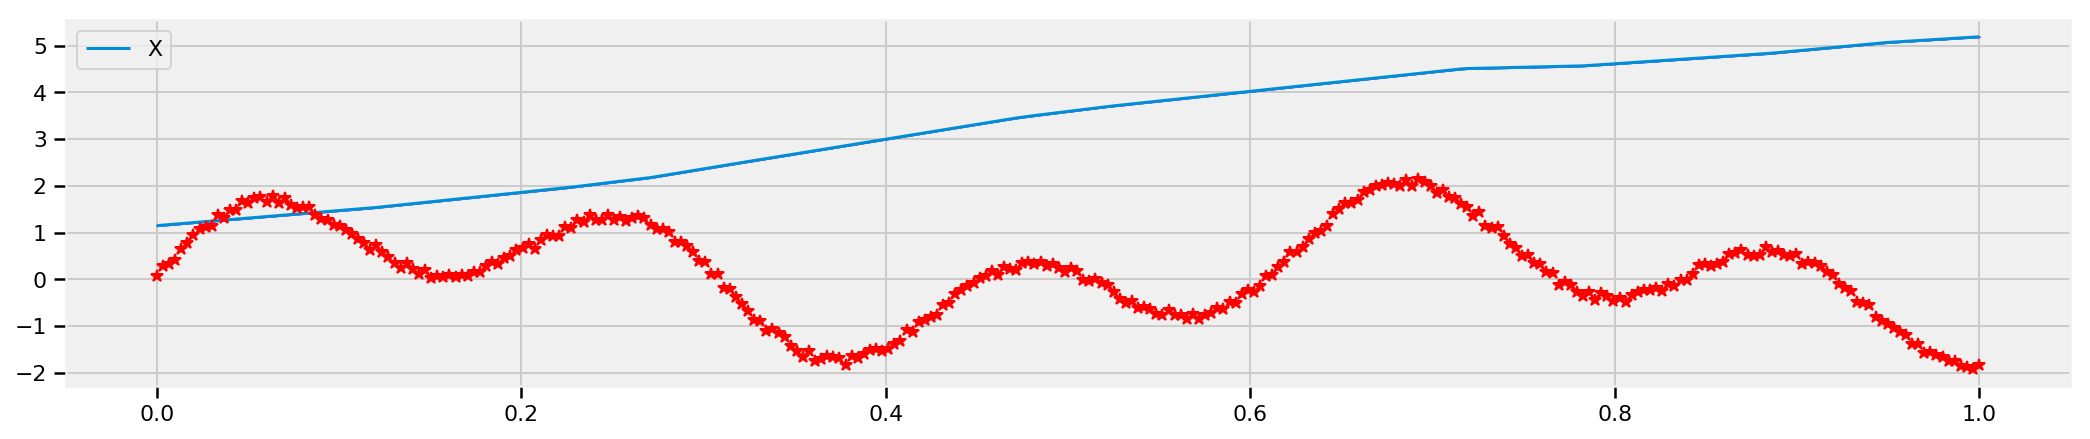

doing a burn in of 3 epochs


  5%|████▏                                                                              | 1/20 [00:04<01:18,  4.13s/it]

rsme is 1.0840364694595337. 
 Coverage is 0.09. 
 COBEAU is (0.6539557, 5.46617484522377e-38).


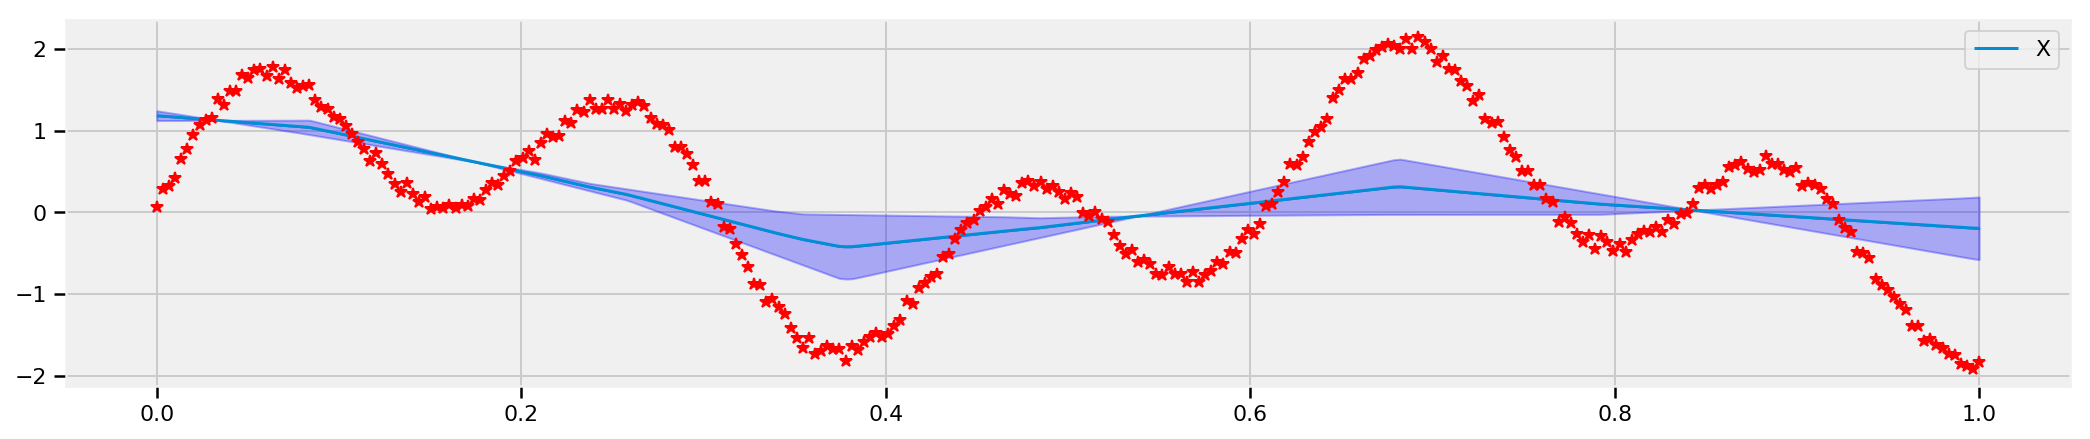

doing a burn in of 3 epochs


 10%|████████▎                                                                          | 2/20 [00:06<01:07,  3.72s/it]

rsme is 1.1263890266418457. 
 Coverage is 0.17. 
 COBEAU is (0.3528027, 3.203978360485471e-10).


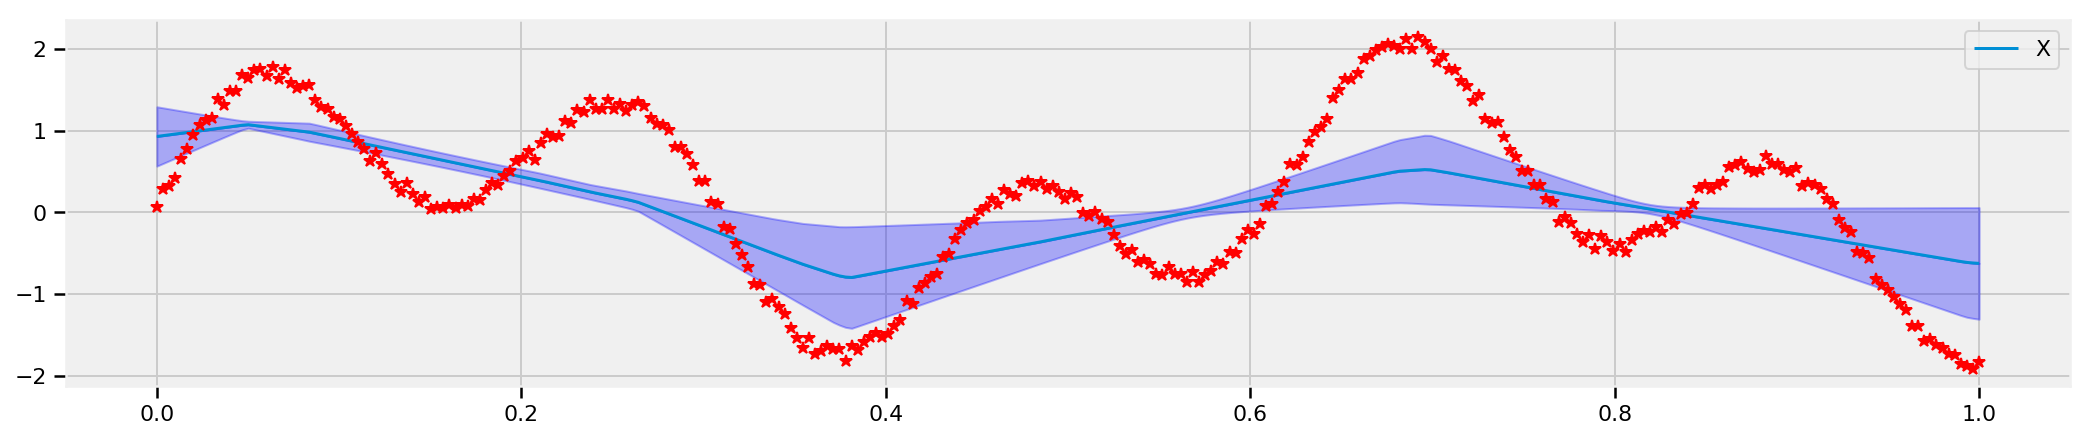

doing a burn in of 3 epochs


 15%|████████████▍                                                                      | 3/20 [00:09<00:58,  3.47s/it]

rsme is 1.2072991132736206. 
 Coverage is 0.16. 
 COBEAU is (0.33824846, 1.8289085921437494e-09).


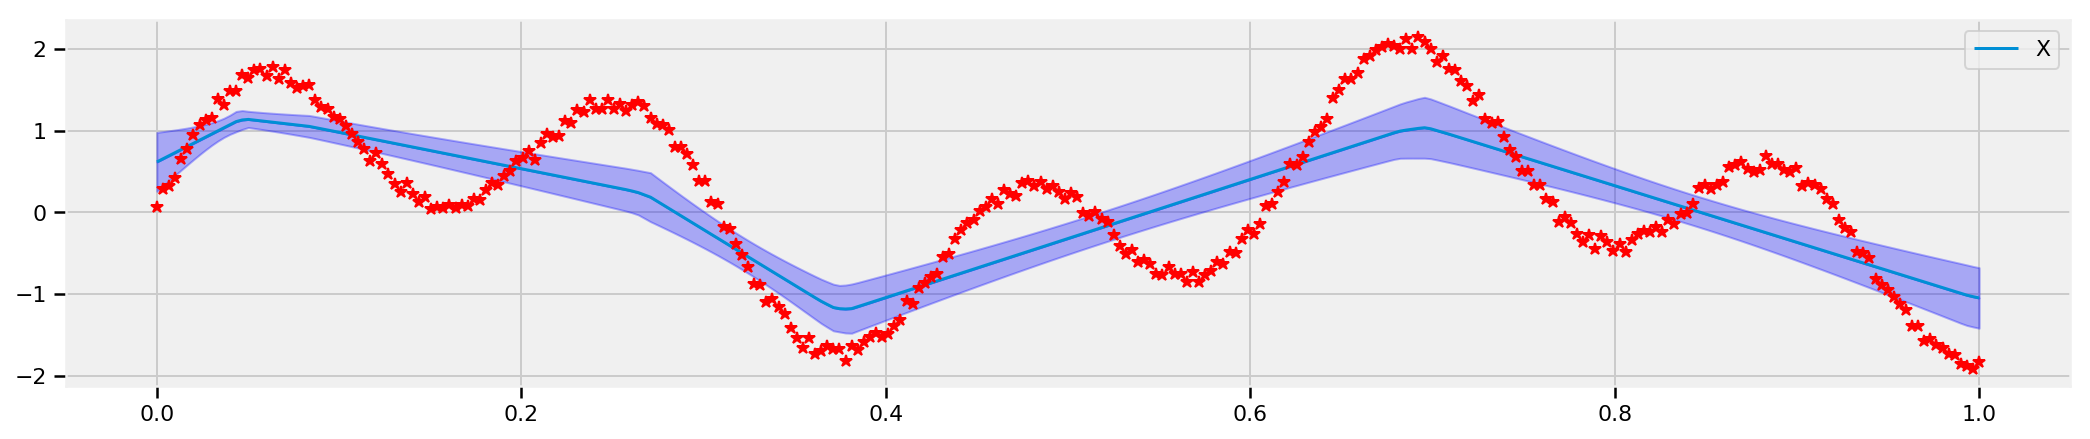

doing a burn in of 3 epochs


 20%|████████████████▌                                                                  | 4/20 [00:12<00:52,  3.31s/it]

rsme is 1.2635877132415771. 
 Coverage is 0.14. 
 COBEAU is (0.351517, 3.750525567249973e-10).


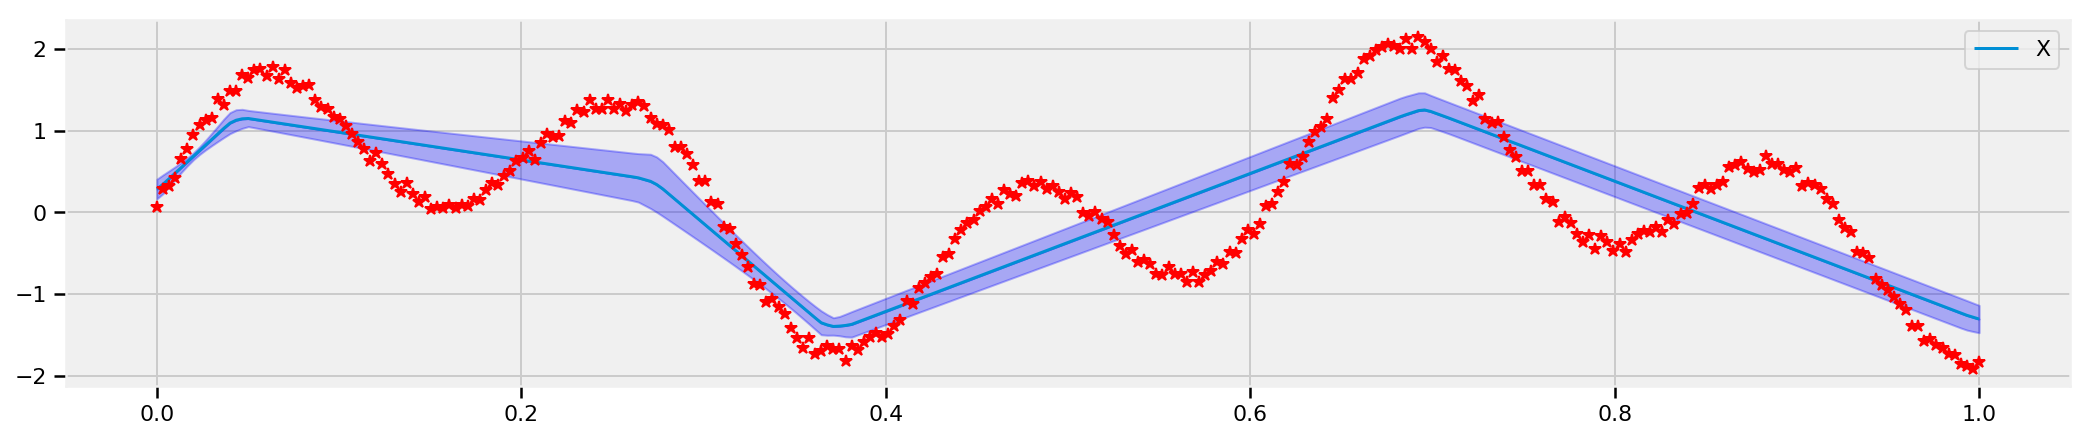

doing a burn in of 3 epochs


 25%|████████████████████▊                                                              | 5/20 [00:15<00:47,  3.18s/it]

rsme is 1.2690887451171875. 
 Coverage is 0.06666666666666667. 
 COBEAU is (0.14031835, 0.015003923886328104).


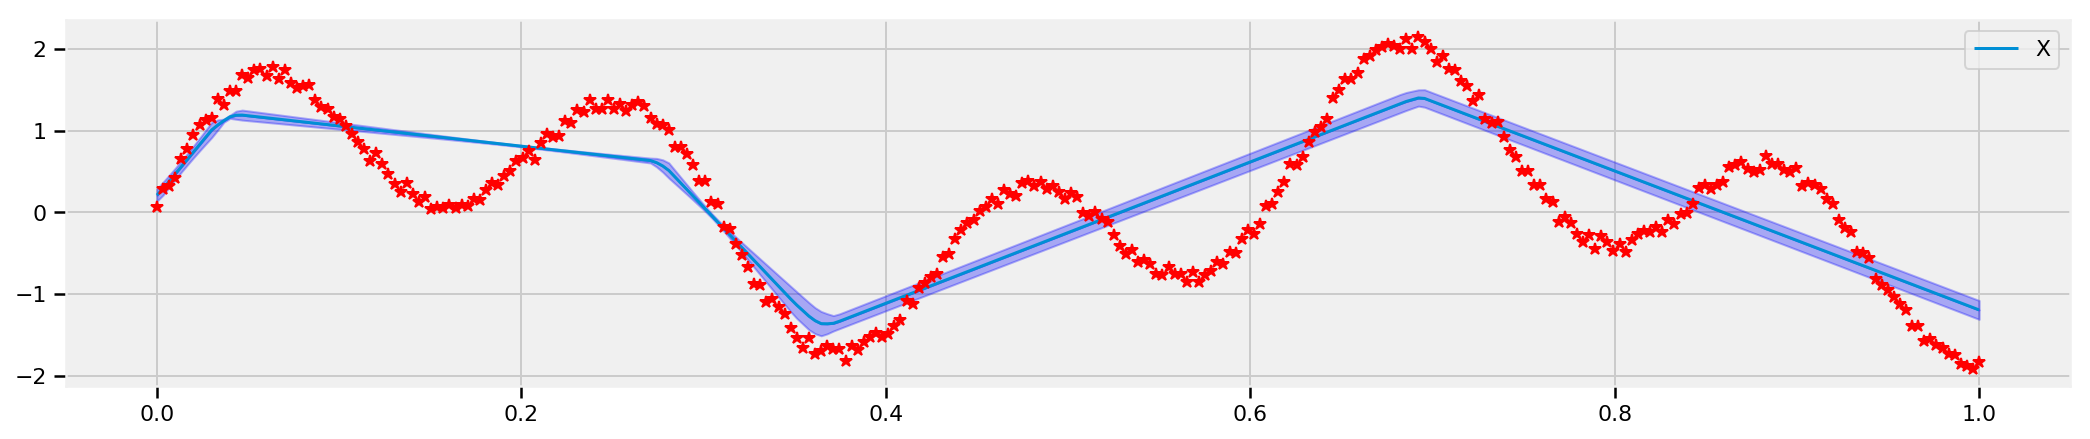

doing a burn in of 3 epochs


 30%|████████████████████████▉                                                          | 6/20 [00:18<00:43,  3.11s/it]

rsme is 1.2817649841308594. 
 Coverage is 0.06333333333333334. 
 COBEAU is (0.08382145, 0.1475278110603587).


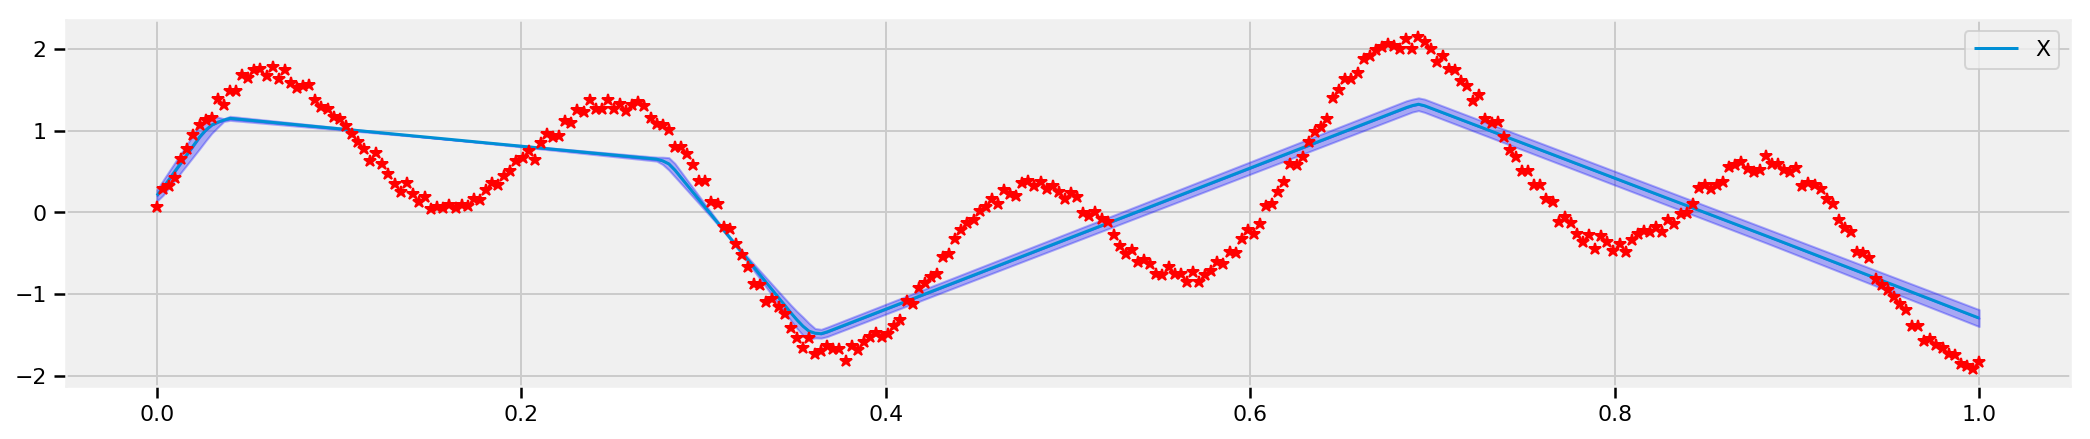

doing a burn in of 3 epochs


 35%|█████████████████████████████                                                      | 7/20 [00:21<00:39,  3.07s/it]

rsme is 1.288482666015625. 
 Coverage is 0.12. 
 COBEAU is (-0.23531312, 3.843688436223394e-05).


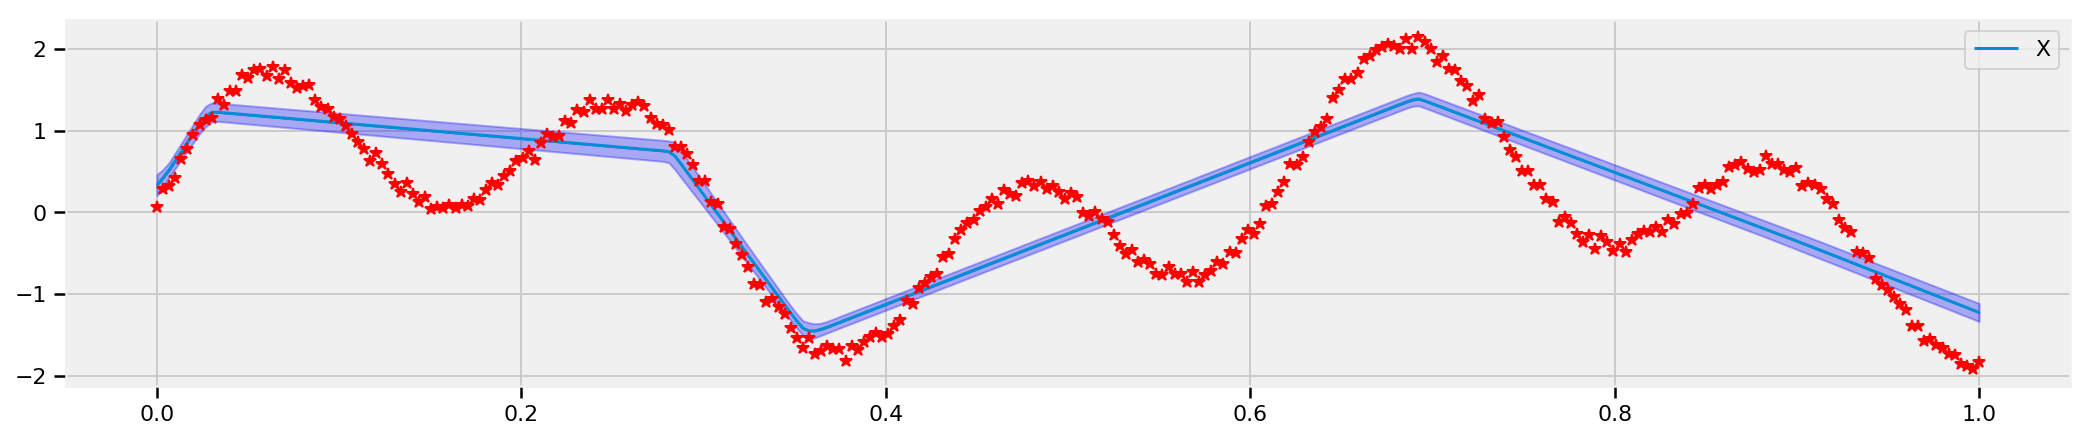

doing a burn in of 3 epochs


 40%|█████████████████████████████████▏                                                 | 8/20 [00:24<00:37,  3.12s/it]

rsme is 1.2984293699264526. 
 Coverage is 0.14666666666666667. 
 COBEAU is (-0.28052947, 7.8871465252405e-07).


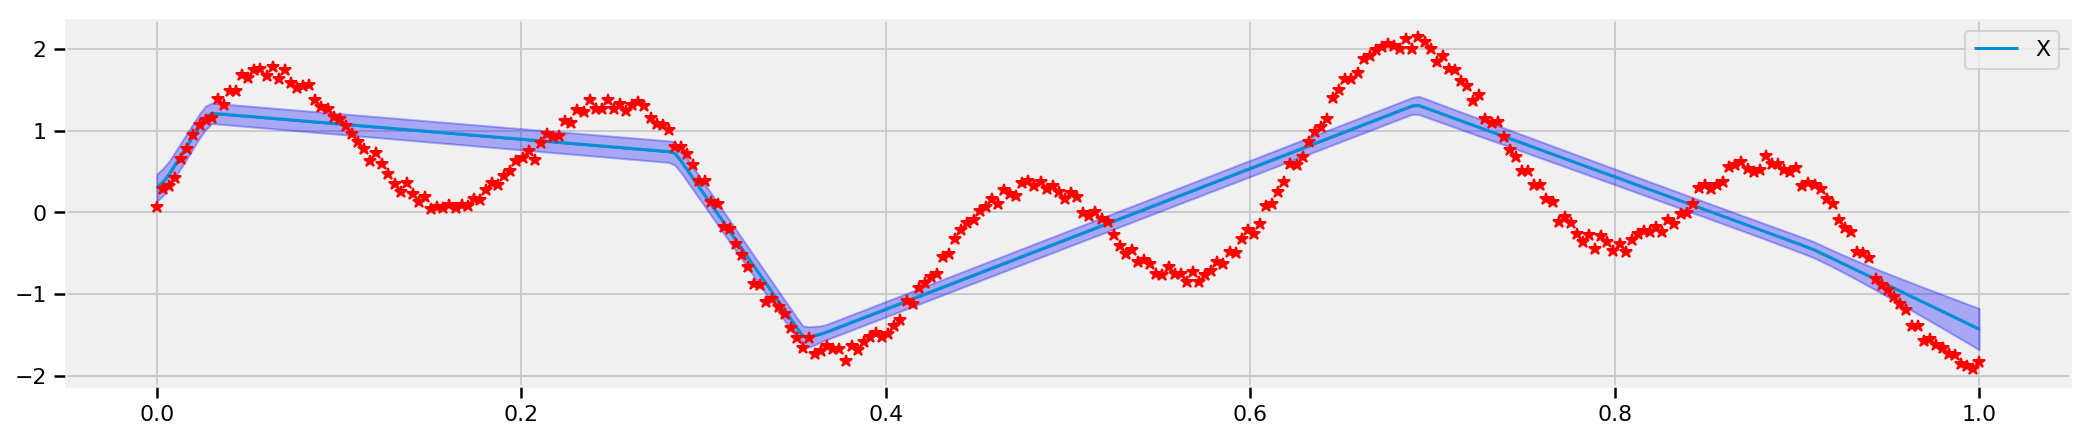

doing a burn in of 3 epochs


 45%|█████████████████████████████████████▎                                             | 9/20 [00:27<00:34,  3.13s/it]

rsme is 1.2945865392684937. 
 Coverage is 0.16333333333333333. 
 COBEAU is (-0.29996008, 1.1822070452468757e-07).


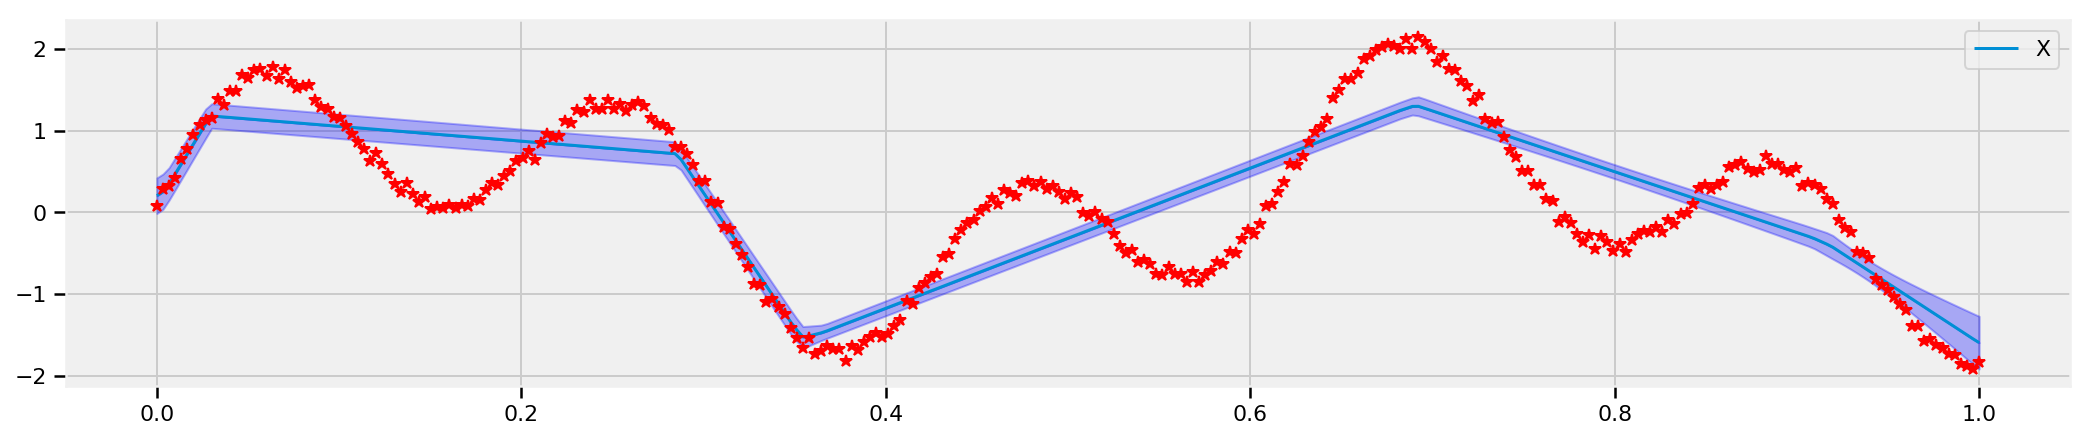

doing a burn in of 3 epochs


 50%|█████████████████████████████████████████                                         | 10/20 [00:30<00:30,  3.09s/it]

rsme is 1.2993414402008057. 
 Coverage is 0.11333333333333333. 
 COBEAU is (-0.08491763, 0.14228690084591863).


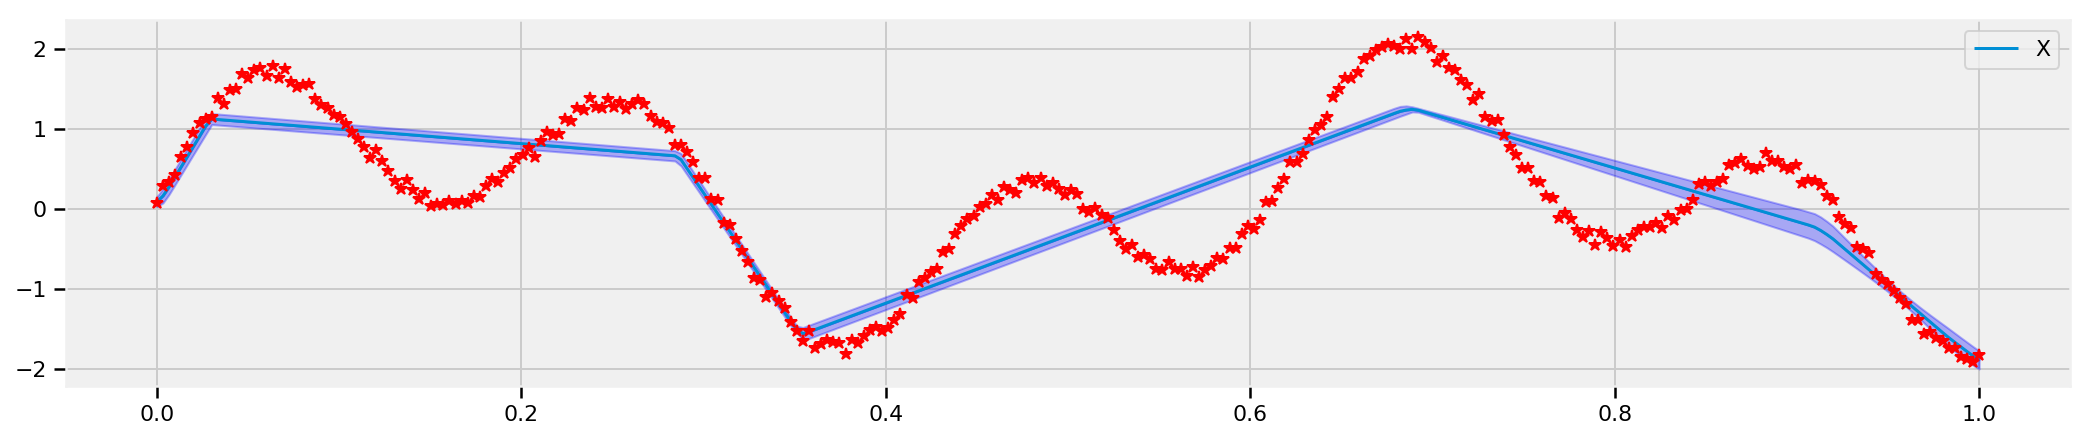

doing a burn in of 3 epochs


 55%|█████████████████████████████████████████████                                     | 11/20 [00:34<00:28,  3.12s/it]

rsme is 1.3021905422210693. 
 Coverage is 0.14333333333333334. 
 COBEAU is (-0.3247021, 8.548516015546549e-09).


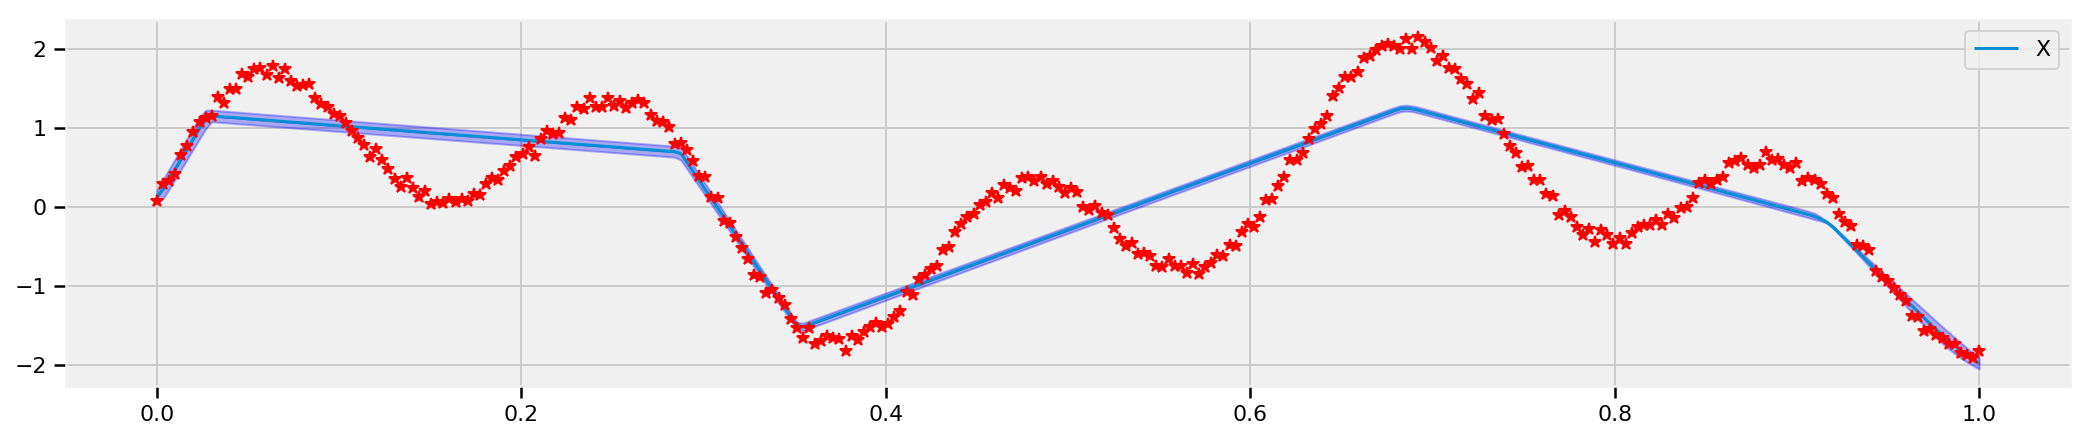

doing a burn in of 3 epochs


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:37<00:24,  3.08s/it]

rsme is 1.3085732460021973. 
 Coverage is 0.12666666666666668. 
 COBEAU is (0.07214589, 0.2127603484906153).


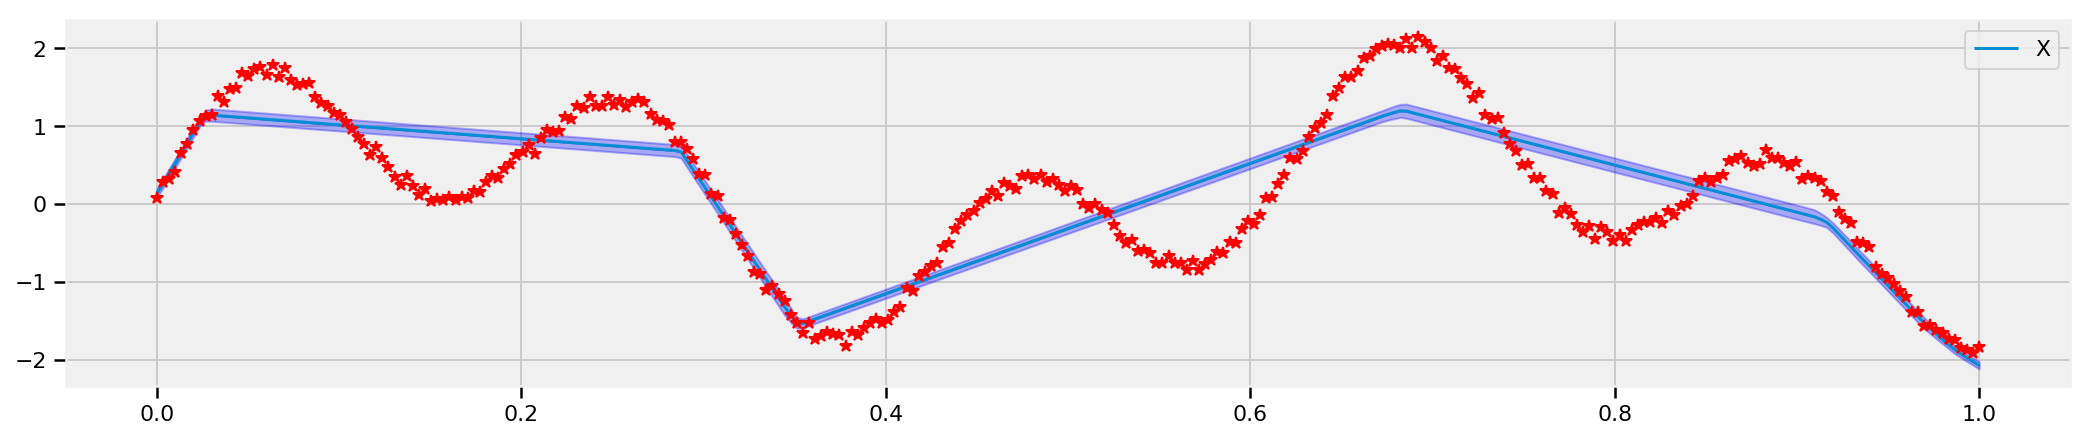

doing a burn in of 3 epochs


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:40<00:21,  3.08s/it]

rsme is 1.3093198537826538. 
 Coverage is 0.15333333333333332. 
 COBEAU is (-0.35455784, 2.5811459586414436e-10).


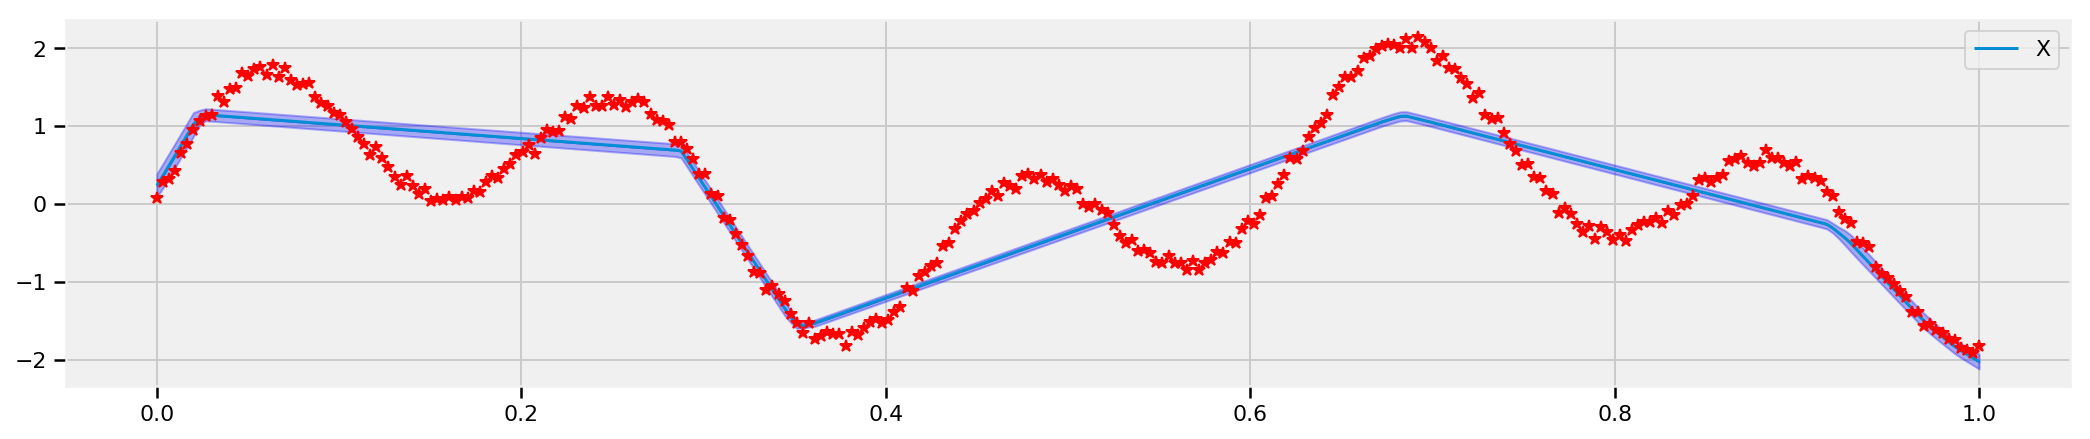

doing a burn in of 3 epochs


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:43<00:18,  3.09s/it]

rsme is 1.304826021194458. 
 Coverage is 0.24333333333333335. 
 COBEAU is (-0.34883907, 5.194892673207961e-10).


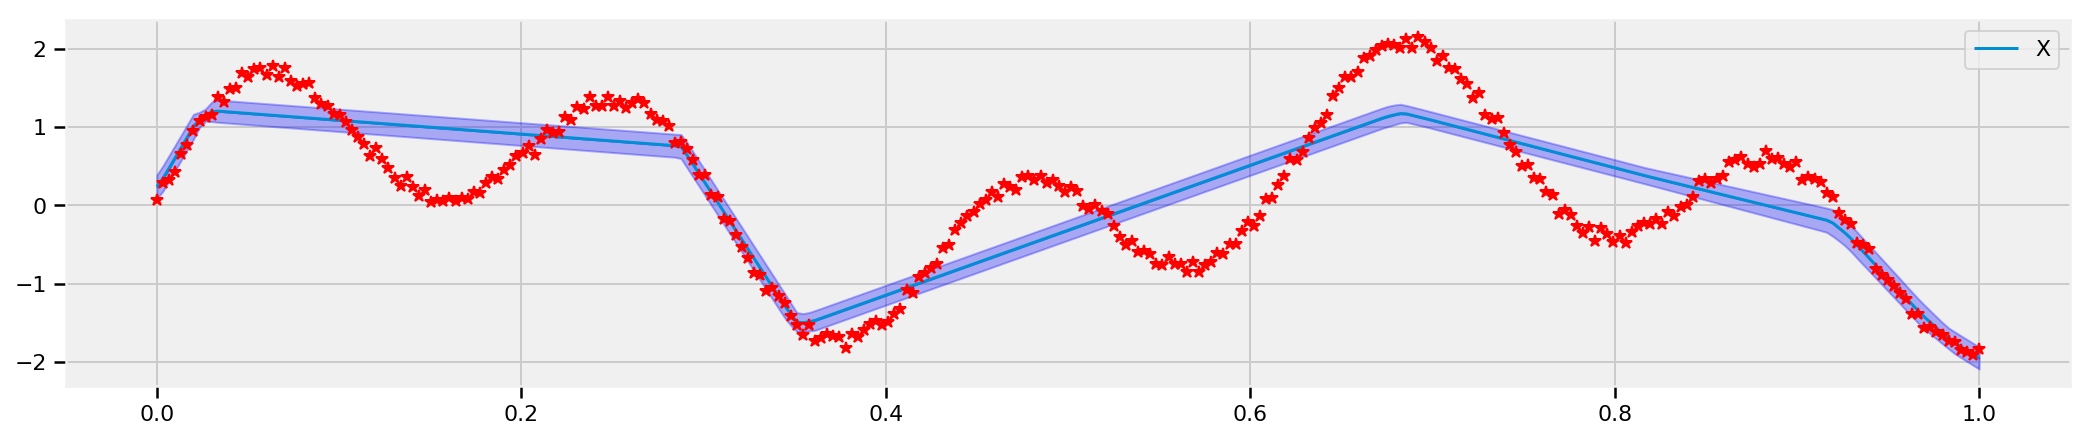

doing a burn in of 3 epochs


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:46<00:15,  3.09s/it]

rsme is 1.3085904121398926. 
 Coverage is 0.26. 
 COBEAU is (-0.24993671, 1.1830868049039108e-05).


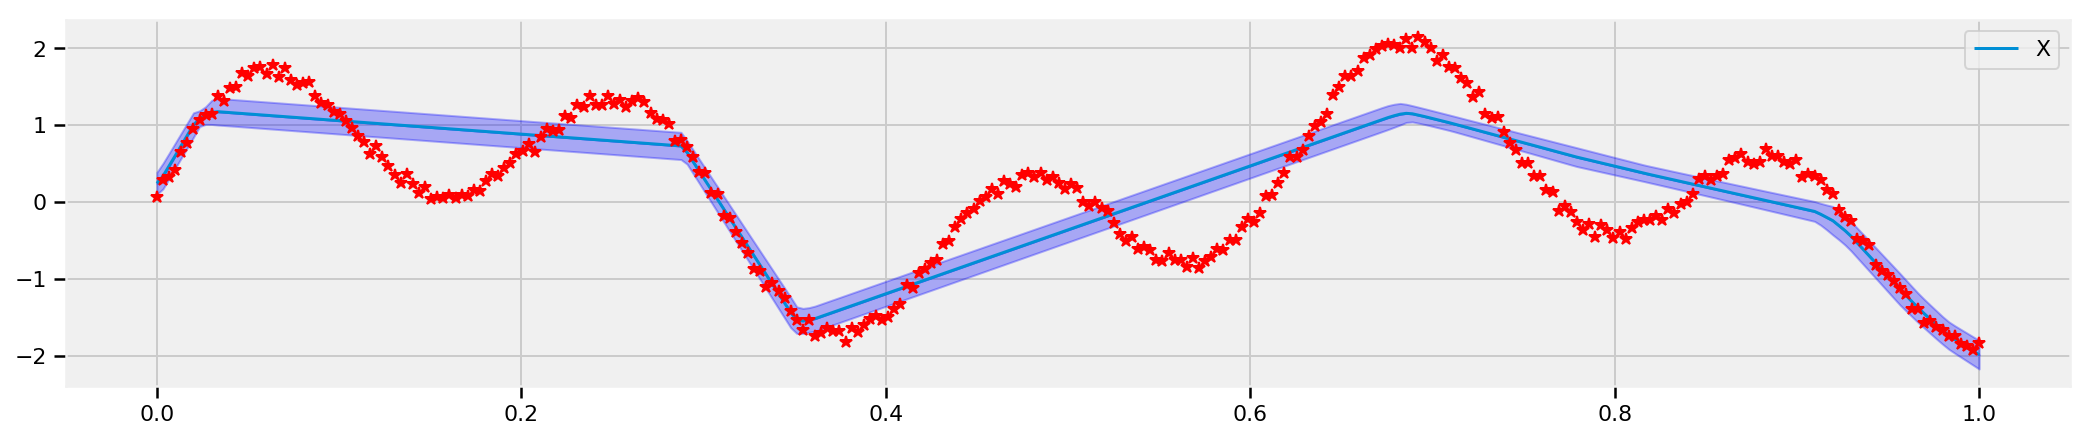

doing a burn in of 3 epochs


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:49<00:12,  3.18s/it]

rsme is 1.304076910018921. 
 Coverage is 0.25333333333333335. 
 COBEAU is (-0.13322023, 0.02099321842929858).


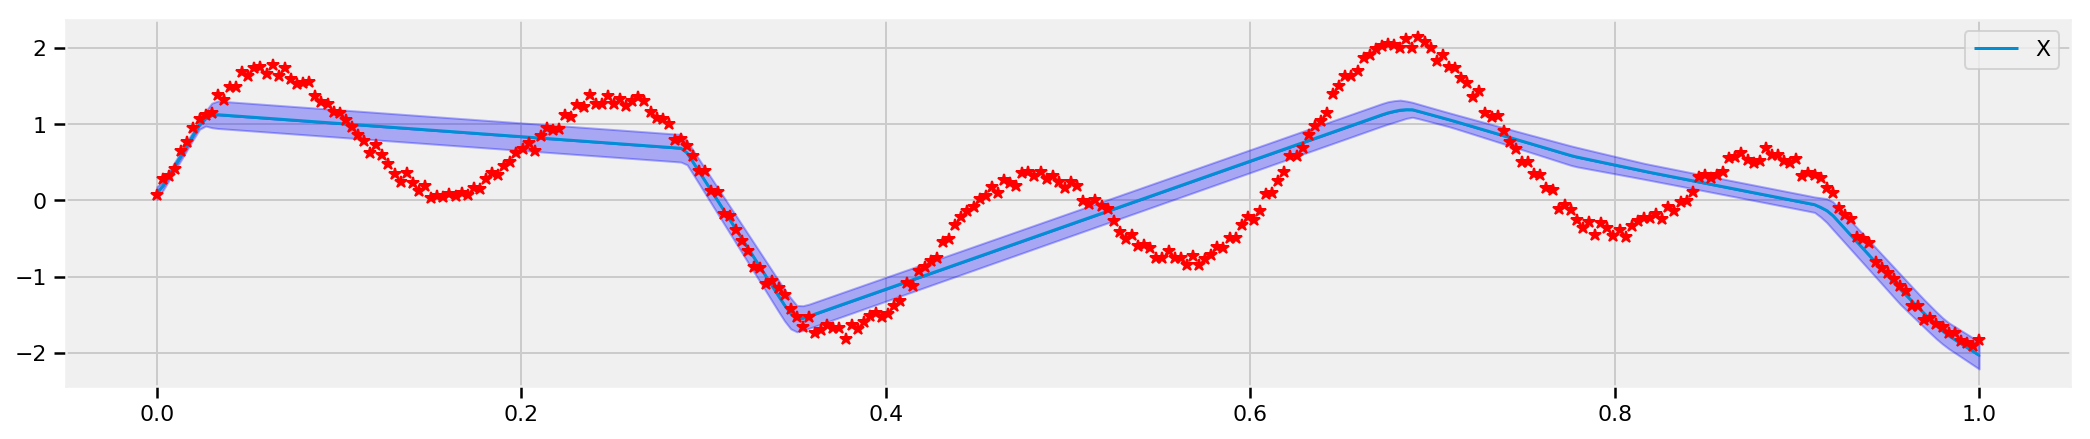

doing a burn in of 3 epochs


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:53<00:09,  3.25s/it]

rsme is 1.3049218654632568. 
 Coverage is 0.07333333333333333. 
 COBEAU is (0.23275158, 4.689459733307966e-05).


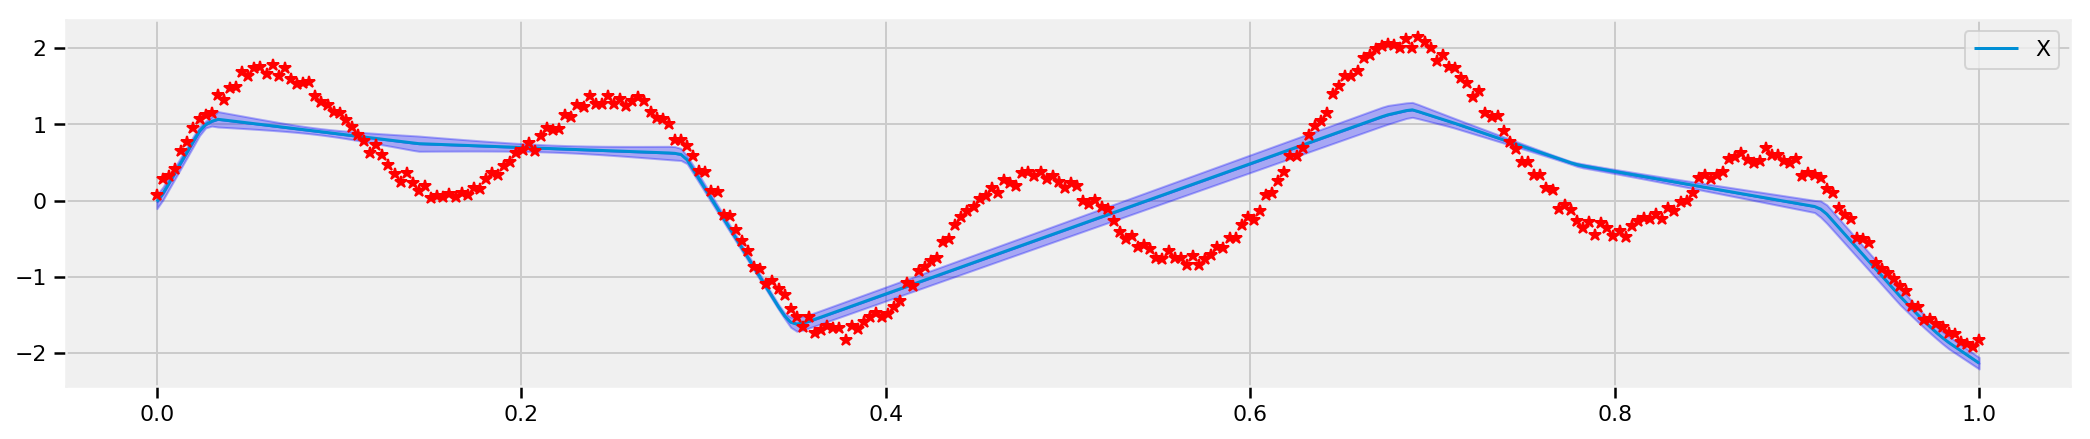

doing a burn in of 3 epochs


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:56<00:06,  3.25s/it]

rsme is 1.304374098777771. 
 Coverage is 0.06333333333333334. 
 COBEAU is (-0.05009919, 0.38722323940042724).


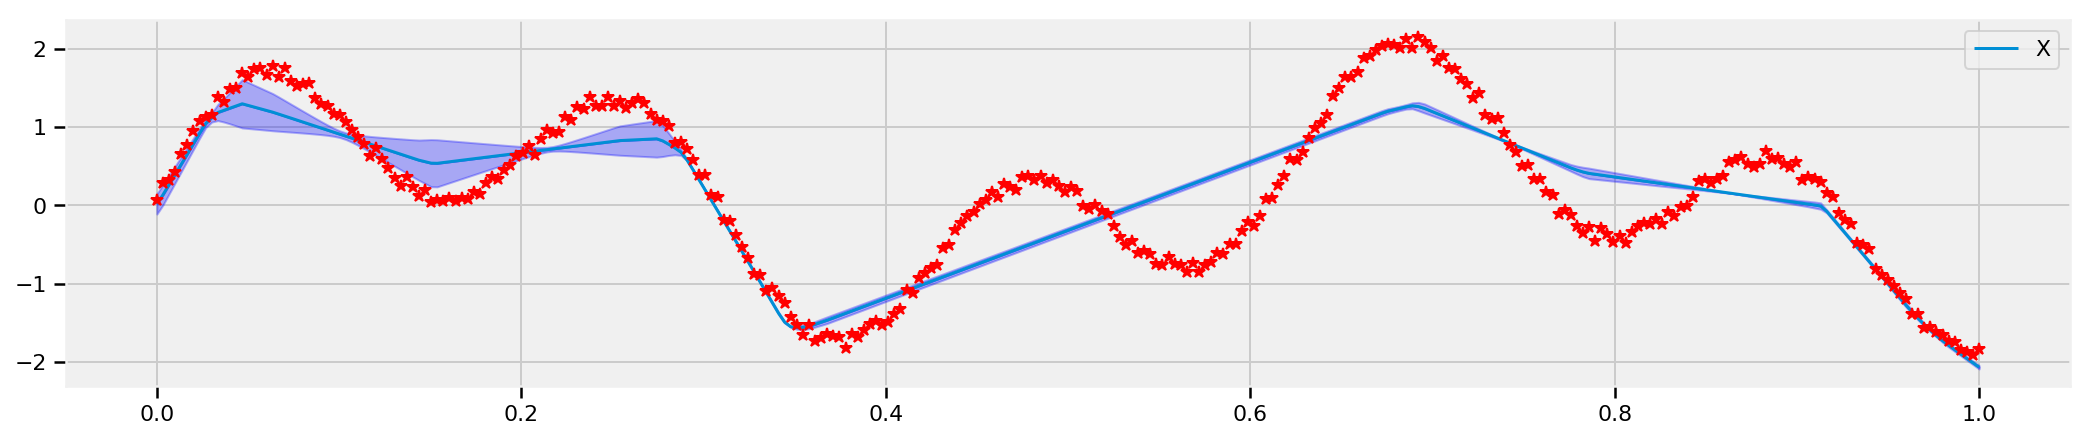

doing a burn in of 3 epochs


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:59<00:03,  3.23s/it]

rsme is 1.314699649810791. 
 Coverage is 0.15. 
 COBEAU is (-0.17562461, 0.002265871272325452).


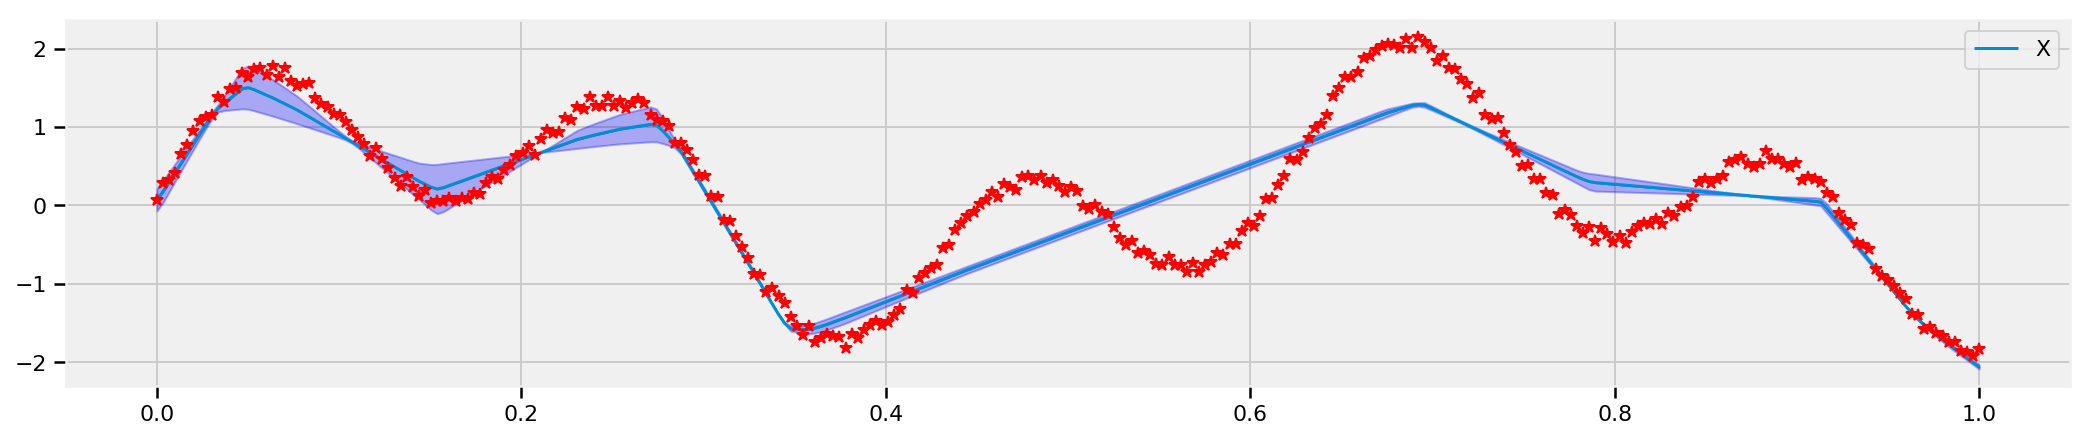

doing a burn in of 3 epochs


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.21s/it]


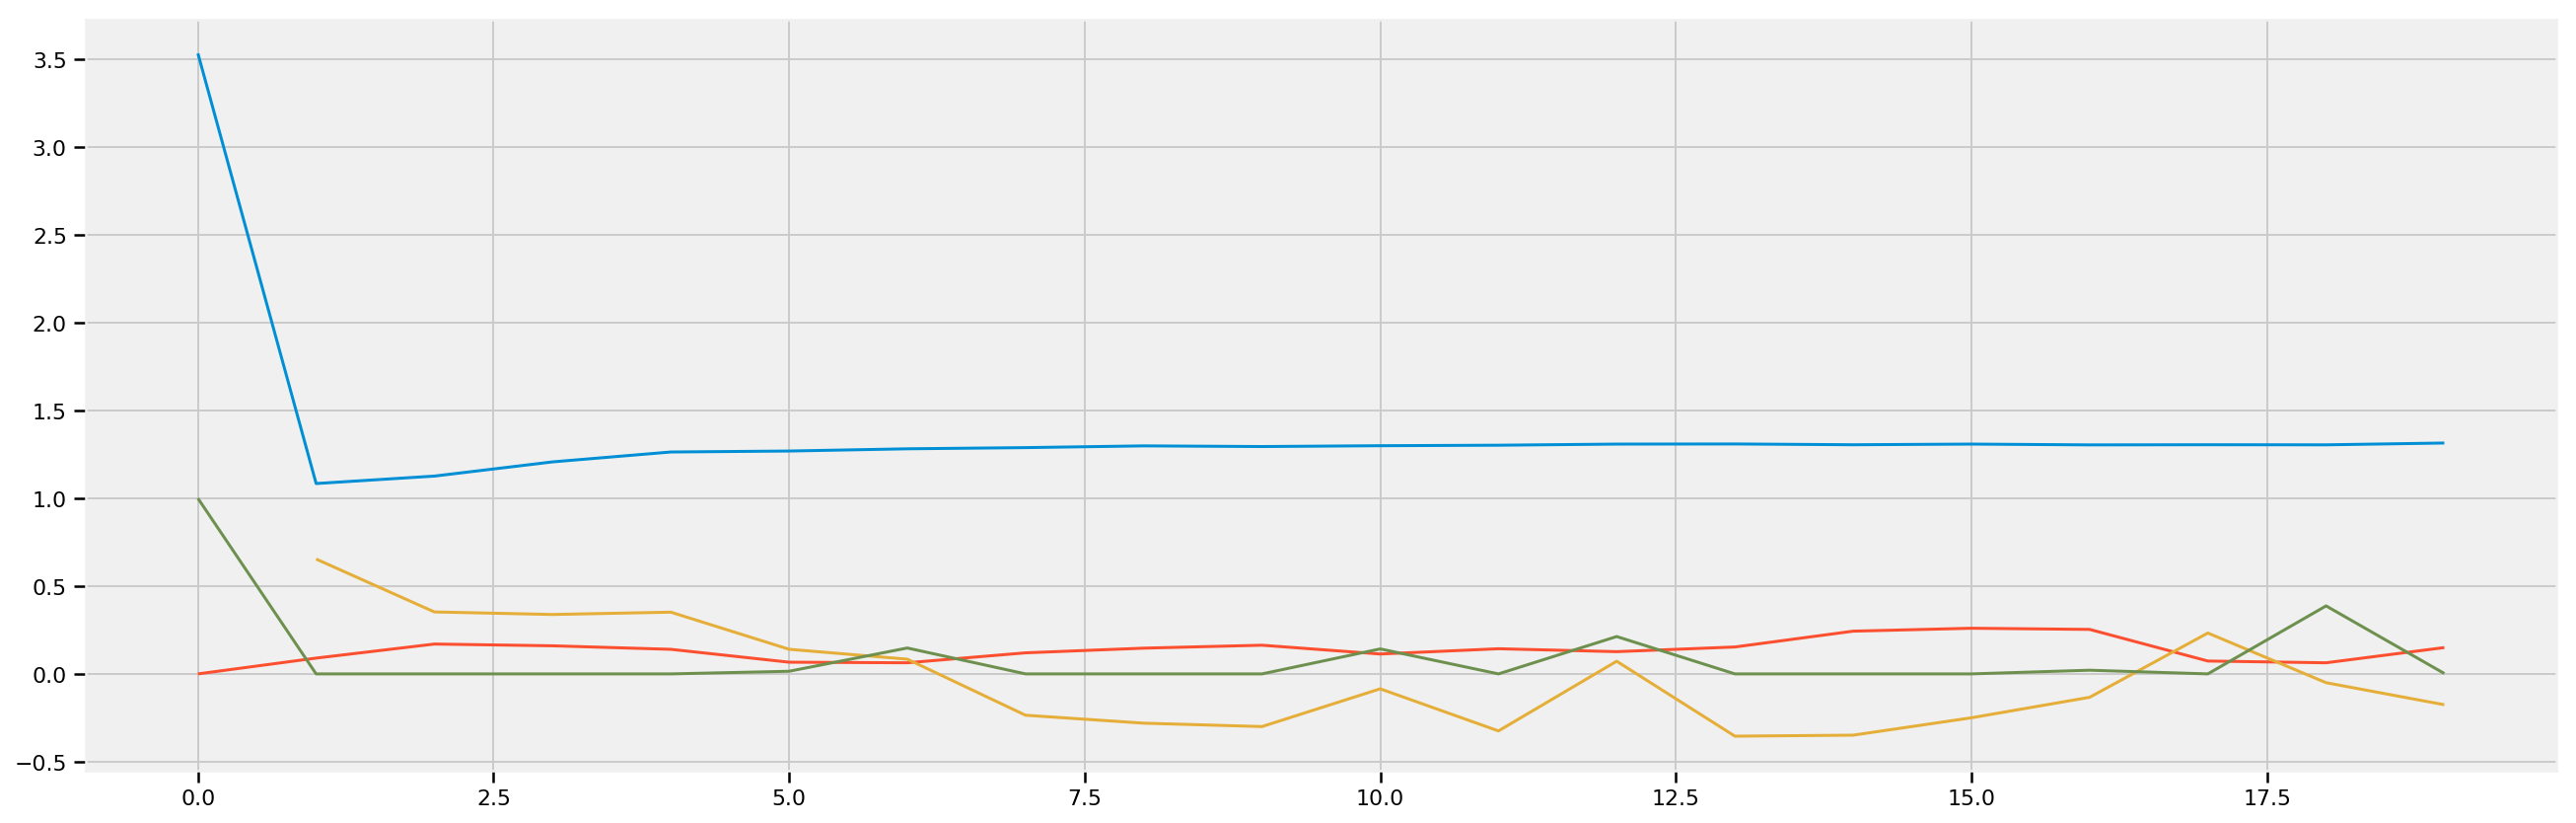

In [27]:
error_list = list()
coverage_list = list()
cobeau_list = list()

for i in tqdm.tqdm(range(meta_epochs)):


  mean, var = get_mean_var(van.predict(X))
  plt.figure(figsize = (16,8*10))

  plt.subplot(meta_epochs,1,i+1)
  plt.plot(X,mean,label='X')
  plt.plot(X,y,'r*')
  plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3, color='b')
  plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3, color='b')
  plt.legend()


  error = rmse(mean,y)
  coverage = coverage_probability(mean,var,y)
  cobeau = error_uncertainty_correlation(mean,var,y)
    
  error_list.append(error)
  coverage_list.append(coverage)
  cobeau_list.append(cobeau)

  print('rsme is {}. \n Coverage is {}. \n COBEAU is {}.'.format(error,coverage,cobeau))


  

  plt.show()
  a = van.fit(25)

plt.figure()
plt.plot(error_list,label='error')
plt.plot(coverage_list,label='coverage')
plt.plot(cobeau_list,label='cobeau')

In [28]:
van.plot(X,y)

IndexError: invalid index to scalar variable.

Bootstrap-ish


In [ ]:
with tf.Graph().as_default() as g_1:
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(100)
  dataset = dataset.batch(100)
  it = dataset.make_one_shot_iterator()
  get_next = tf.identity(it.get_next(), name = 'next')
  X_ =  tf.identity(it.get_next()[0], name="X")
  y_ =  tf.identity(it.get_next()[1], name="y")

  gdef = g_1.as_graph_def()
  
  #g_1.get_tensor_by_name('X:0')
  #g_1.get_tensor_by_name("y:0")

  #it = dataset.make_one_shot_iterator()

#X,y = it.get_next()

In [ ]:
plt.plot(nn.predict(X[10:50]))
plt.plot(y[10:50])
#plt.plot(nn.predict_meh())

In [ ]:
tf.reset_default_graph()


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(12, input_dim=1, kernel_initializer='normal', activation='tanh'))
model.add(tf.keras.layers.Dense(8, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear'))


model.compile(loss='mse', optimizer='adam', )#metrics=['mse','mae'])


model.summary()

In [ ]:
model.fit(dataset, epochs=1000, steps_per_epoch=10)

In [ ]:
plt.plot(model.predict(X)[:100])
plt.plot(y[:100])

In [ ]:
tf.reset_default_graph()


import numpy as np
import tensorflow as tf
keras = tf.keras

# tf.data.Dataset instance
tr_data = np.random.random((1000, 32)).astype(np.float32)
tr_label = np.random.randint(low=0, high=10, size = 1000).astype(np.int32)
tr_dataset = tf.data.Dataset.from_tensor_slices((tr_data, tr_label))
tr_dataset = tr_dataset.batch(batch_size=32)
tr_dataset = tr_dataset.repeat()

val_data = np.random.random((100, 32)).astype(np.float32)
val_label = np.random.randint(low=0, high=10, size = 100).astype(np.int32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_label))
val_dataset = val_dataset.batch(batch_size=100).repeat()

# Training
model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=10, activation='softmax'))
model.compile(optimizer=tf.train.GradientDescentOptimizer(.01), 
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model.fit(tr_dataset, epochs = 5, steps_per_epoch = 1000 // 32,
          validation_data = val_dataset, validation_steps = 1)

In [ ]:
# with Session
tf.reset_default_graph()

with tf.Session() as sess:
  sess.run(predict)

In [ ]:
tf.reset_default_graph()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.repeat()
dataset = dataset.shuffle(1)
dataset = dataset.batch(10)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.compile(optimizer='adam', loss='mean_squared_error')
# This builds the model for the first time:


In [ ]:
model.fit(dataset.make_one_shot_iterator().get_next()[0],dataset.make_one_shot_iterator().get_next()[1], epochs=5, steps_per_epoch=10)

In [ ]:
nn.fit_dataset(X,y)

In [ ]:
import tensorflow as tf
import numpy as np

class Network:
    def __init__(self, x_in, input_size):
        self.input_size = input_size
        # self.x_in = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size))  # Original
        self.x_in = x_in
        self.output_size = 3

        #tf.reset_default_graph()  # This turned out to be the problem

        self.layer = tf.layers.dense(self.x_in, self.output_size, activation=tf.nn.relu)
        self.loss = tf.reduce_sum(tf.square(self.layer - tf.constant(0, dtype=tf.float32, shape=[self.output_size])))

data_array = np.random.standard_normal([4, 10]).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data_array).batch(2)

model = Network(x_in=dataset.make_one_shot_iterator().get_next(), input_size=dataset.output_shapes[-1])

NEW


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn import datasets

# 推論

def inference(x):
    with tf.name_scope('l1') as scope:
        w_l1 = tf.Variable(tf.truncated_normal(
            [10, 256], stddev=0.33), name="w_l1")
        b_l1 = tf.Variable(tf.constant(1.0, shape=[256]), name="b_l1")
        h_l1 = tf.nn.relu(tf.matmul(x, w_l1) + b_l1)

    with tf.name_scope('l2') as scope:
        w_l2 = tf.Variable(tf.truncated_normal(
            [256, 1], stddev=0.33), name="w_l2")
        b_l2 = tf.Variable(tf.constant(1.0, shape=[1]), name="b_l2")
        output = tf.nn.relu(tf.matmul(h_l1, w_l2) + b_l2)

    return output

# 損失関数
def loss(model, y):
    return tf.reduce_mean(tf.square(model - y), name="loss")

# 学習
def training(loss, rate):
    return tf.train.AdagradOptimizer(rate).minimize(loss)

def main():
    diabetes = datasets.load_diabetes()
    data = diabetes["data"].astype(np.float32)
    target = diabetes['target'].astype(
        np.float32).reshape(len(diabetes['target']), 1)

    MAX_SIZE = data.shape[0]
    TEST_N = 100
    N = MAX_SIZE - TEST_N
    BATCH_SIZE = 10
    MAX_STEPS = 300

    train_x, test_x = np.vsplit(data, [N])
    train_y, test_y = np.vsplit(target, [N])

    # symbolic variables
    x = tf.placeholder(tf.float32, shape=[None, 10])
    y = tf.placeholder(tf.float32, shape=[None, 1])

    model = inference(x)
    loss_value = loss(model, y)
    train_op = training(loss_value, 0.04)

    best = float("inf")
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        for step in range(MAX_STEPS + 1):
            for i in range(N // BATCH_SIZE):
                batch = BATCH_SIZE * i
                train_batch_x = train_x[batch:batch + BATCH_SIZE]
                train_batch_y = train_y[batch:batch + BATCH_SIZE]

                loss_train = sess.run(loss_value, feed_dict={
                                      x: train_batch_x, y: train_batch_y})
                sess.run(train_op, feed_dict={
                         x: train_batch_x, y: train_batch_y})

            if loss_train < best:
                best = loss_train
                best_match = sess.run(model, feed_dict={x: test_x, y: test_y})

            if step % 10 == 0:
                cor = np.corrcoef(best_match.flatten(), test_y.flatten())
                print('step : {}, train loss : {}, test cor : {}'.format(
                    step, best, cor[0][1]))

In [ ]:
main()